In [1]:
import sys
import json
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

sys.path.append('../..')
from anndata import AnnData
from utils import UnimapResult, set_plot_theme
from matplotlib.colors import LinearSegmentedColormap

set_plot_theme()
warnings.filterwarnings('ignore')

/home/hht/.conda/envs/unimap1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### FIG3 SUP6

In [2]:
result = UnimapResult('pbmc40', 'unimap/2023', root_dir='../../results', detailed=False)
umap1 = result.st_umap_result['umap1']
umap2 = result.st_umap_result['umap2']

batch_labels = result.st_result['batch']
ct_labels = ['reference'] * len(result.s_result) + list(result.t_result['celltype'])
pd_ct_labels = ['reference'] * len(result.s_result) + list(result.t_result['pred_celltype'])

In [3]:
color_dict = json.load(open('../../color_dict.json'))
pd_ct_c = color_dict["pbmc40_ct_ref"]
ct_c = color_dict["pbmc40_ct_query"]
ct_order = color_dict["pbmc40_ct_query_order"]
pd_ct_order = list(color_dict["pbmc40_ct_ref"].keys())

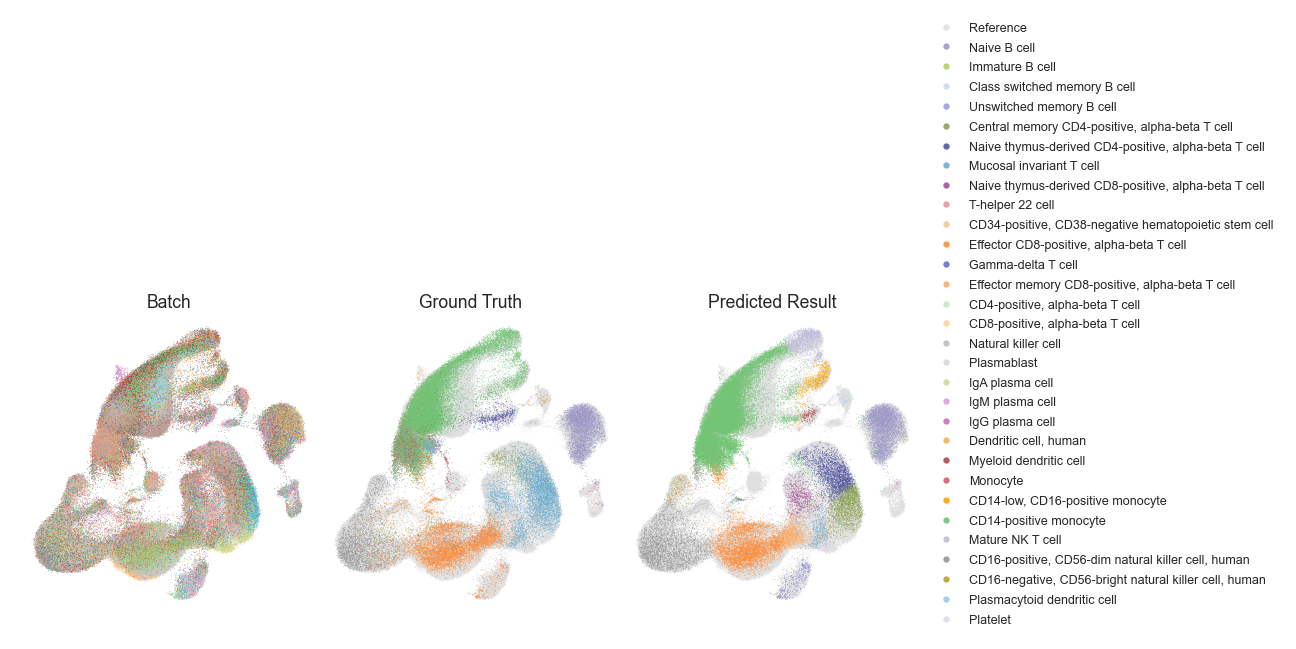

In [4]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()
w, h = 0.23, 0.23 / (250/185)
l, b, x = 0.04, 0.20, 0.02
positions = [[0.02, 0.35, w, h], [0.25, 0.35, w, h], [0.48, 0.35, w, h]]

p0 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=0.1, hue=batch_labels, edgecolor='none', palette=result.color20, ax=fig.add_axes(positions[0]), rasterized=True)
p1 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=0.1, hue=ct_labels,    edgecolor='none', palette=ct_c,           ax=fig.add_axes(positions[1]), rasterized=True)
p2 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=0.1, hue=pd_ct_labels, edgecolor='none', palette=pd_ct_c,        ax=fig.add_axes(positions[2]), rasterized=True)


p0 = result.remove_ticks(p0)
p1 = result.remove_ticks(p1)
p2 = result.remove_ticks(p2)
p0 = result.remove_spines(p0, remove_legend=True)
p1 = result.remove_spines(p1, remove_legend=True)
p2 = result.remove_spines(p2, remove_legend=True)
# p0.spines['top'].set_visible(False)

p0.set_title('Batch',            fontsize=7, pad=2)
p1.set_title('Ground Truth',     fontsize=7, pad=2)
p2.set_title('Predicted Result', fontsize=7, pad=2)

# pd_ct_labels_order = [label for label in sorted(set(pd_ct_labels)) if label != 'reference']
# pd_ct_labels_order.insert(0, 'reference')
handles, labels = p2.get_legend_handles_labels()
ordered_handles = [handles[labels.index(label)] for label in pd_ct_order if label in labels]
ordered_labels = [label[0].upper() + label[1:] for label in pd_ct_order if label in labels]

p2 = p2.legend(handles=ordered_handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 2.0), frameon=False, markerscale=8, fontsize=5, labelspacing=0.6, ncols=1)  # 

### heatmap

In [5]:
result = UnimapResult('pbmc40', 'unimap/2023', root_dir='../../results', detailed=False)
cm = result.get_cm(percentage_direction=1, ct_labels=ct_order, pd_ct_labels=pd_ct_order[1:])

colors = ['#f4f3f8', '#827fbb'] 
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

ax = sns.heatmap(cm, annot=True, cmap=custom_cmap, annot_kws={'size': 4}, fmt='.2f', cbar=False, square=True, mask=cm < 0.02, xticklabels=pd_ct_order[1:], yticklabels=ct_order, ax=fig.add_axes([0.17, 0.52, 0.54, 0.2]))
# ax = result.remove_spines(ax, re)
ax = result.remove_spines(ax, sp_v=True)
ax.set_yticklabels([(label[0].upper() + label[1:]) for label in ct_order], rotation=0, fontsize=5)
ax.set_xticklabels(['■'] * (len(pd_ct_order) - 1), ha='center', fontsize=12)
ax.xaxis.tick_top()
ax.xaxis.set_tick_params(labelsize=10, pad=0)
ax.tick_params(bottom=False, top=True, left=True, right=False, length=1.5, width=0.5)
ax.set_ylabel('Ground Truth', fontsize=7,labelpad=5)
ax.set_xlabel('Predicted Result', fontsize=7,labelpad=5)
ax.xaxis.set_label_position('top')
for tick, color in zip(ax.get_xticklabels(), list(pd_ct_c.values())[1:]):
    tick.set_color(color)


In [6]:
pbmc_query = sc.read_h5ad( '../../data/pbmc40/pbmc10.h5ad')
pbmc_hvgs = pkl.load(open( '../../data/pbmc40/hvg_1582_pbmc40.pkl', "rb"))
result = UnimapResult('pbmc40', 'unimap/2023', root_dir='../../results')

pbmc_query.obs = pd.concat([pbmc_query.obs, result.t_result.loc[:, ['pred_celltype', 'pred_cell_prob']]], axis=1)
# pbmc_query.var.set_index('feature_name', inplace=True)
pbmc_query.var_names_make_unique()
pbmc_query = pbmc_query[pbmc_query.obs['celltype'] != 'nan', :]
sc.pp.filter_cells(pbmc_query, min_genes=200)
sc.pp.filter_genes(pbmc_query, min_cells=3)
sc.pp.normalize_total(pbmc_query, target_sum=1e6)  # cpm
sc.pp.log1p(pbmc_query)
pbmc_query = pbmc_query[:, pbmc_query.var.index.isin(pbmc_hvgs)]
pbmc_query.raw = pbmc_query
pbmc_query.obsm['X_umap'] = result.t_umap_result.reindex(pbmc_query.obs_names).to_numpy()
pbmc_query.obsm['X_pca'] = result.t_z_result.reindex(pbmc_query.obs.index).values


Checking pbmc40 unimap/2023 result 
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ File                 ┃ Exist    ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ st_result.csv        │ ✔️        │
│ history.csv          │ ✔️        │
│ st_z_result.csv      │ ✔️        │
│ st_umap_result.csv   │ ✔️        │
│ t_prob_result.csv    │ ✔️        │
└──────────────────────┴──────────┘

In [7]:
postions = [[0.02, 0.18, 0.17, 0.17 / (250/185)],
            [0.20, 0.19, 0.04, 0.15 / (250/185)],
            [0.30, 0.18, 0.17, 0.17 / (250/185)],
            [0.48, 0.19, 0.06, 0.15 / (250/185)],
            [0.61, 0.18, 0.17, 0.17 / (250/185)],
            [0.79, 0.19, 0.05, 0.15 / (250/185)]]
ax1 = fig.add_axes(postions[0])
ax2 = fig.add_axes(postions[1])
ax3 = fig.add_axes(postions[2])
ax4 = fig.add_axes(postions[3])
ax5 = fig.add_axes(postions[4])
ax6 = fig.add_axes(postions[5])

def cal_gene(adata: AnnData, gene_list: list, groupby_column: str) -> pd.DataFrame:
    valid_genes = [gene for gene in gene_list if gene in adata.var_names]
    expression_matrix = adata[:, valid_genes].X
    groups = adata.obs[groupby_column]

    if not isinstance(expression_matrix, np.ndarray):
        expression_matrix = expression_matrix.toarray()

    results = {
        'group': [],
        'gene': [],
        'expression_proportion': [],
        'average_expression': []
    }

    for group in groups.unique():
        group_mask = (groups == group).values
        group_expression = expression_matrix[group_mask, :]
        
        expression_proportion = (group_expression > 0).sum(axis=0) / group_expression.shape[0]
        average_expression = group_expression.mean(axis=0)
        
        for gene, prop, avg in zip(valid_genes, expression_proportion, average_expression):
            results['group'].append(group)
            results['gene'].append(gene)
            results['expression_proportion'].append(prop)
            results['average_expression'].append(avg)

    return pd.DataFrame(results)


def plot_dotplot(adata: AnnData, gene_list: list, groupby_column: str, ax=None, group_color=['#a0a0a0', '#c3a74d'], group_index=None):
    df = cal_gene(adata, gene_list, groupby_column)
    df['gene'] = pd.Categorical(df['gene'], categories=gene_list[::-1], ordered=True)
    df = df.sort_values('gene')
    gene_num = len(gene_list)
    if group_index is None:
        unique_groups = df['group'].unique()
    else:
        unique_groups = group_index
    df['group'] = pd.Categorical(df['group'], categories=unique_groups, ordered=True)
    group_num = len(unique_groups)
    p = sns.scatterplot(data=df, x='group', y='gene', size='expression_proportion', hue='average_expression', palette='viridis', sizes=(0, 35), edgecolor='black', linewidth=0.0, ax=ax)
    p.legend_.remove()
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xlim(-0.5, group_num - 0.5)
    p.set_ylim(-1, gene_num)
    p.set_xticklabels(['■'] * group_num)
    p.set_yticklabels(gene_list[::-1], fontsize=5, fontstyle='italic')
    p.yaxis.tick_right()
    p.xaxis.set_tick_params(labelsize=9, pad=0)
    p.yaxis.set_tick_params(labelsize=5, pad=2)
    p.tick_params(bottom=True, top=False, left=False, right=True, length=1, width=0.5)
    for tick, color in zip(p.get_xticklabels(), group_color):
        tick.set_color(color)

def plot_umap(adata, ax=None, ct_color_dict = {'A': '#c3a74d','B': '#a0a0a0',
}, spinecolor='#565656', title=''):
    p = sns.scatterplot(x=adata.obsm['X_umap'][:,0], y=adata.obsm['X_umap'][:,1], alpha=0.9, s=0.25, hue=adata.obs.pred_celltype, edgecolor='none', palette=ct_color_dict, ax=ax, rasterized=True)
    p = result.remove_ticks(p, remove_legend=True)
    short_dict = {
        'CD16-positive, CD56-dim natural killer cell, human': 'CD16-positive, CD56-dim NK',
        'CD16-negative, CD56-bright natural killer cell, human': 'CD16-negative, CD56-bright NK',
        'central memory CD4-positive, alpha-beta T cell': 'CM CD4+ CD4-positive, αβ T',
        'mucosal invariant T cell': 'MAIT',
        'naive thymus-derived CD4-positive, alpha-beta T cell': 'Naive CD4+, αβ T',
        'naive thymus-derived CD8-positive, alpha-beta T cell': 'Naive CD8+, αβ T',
    }
    ct_color_dict = {short_dict.get(k, k): v for k, v in ct_color_dict.items()}
    custom_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=0.3, label=label) for label, color in ct_color_dict.items()]
    if len(ct_color_dict) > 3:
        p.legend(handles=custom_handles, loc='upper left', bbox_to_anchor=(-0.07, 1), ncol=1, fontsize=5, markerscale=4, frameon=False, handletextpad=-0.5, labelspacing=0.2)
    else:
        p.legend(handles=custom_handles, loc='lower left', bbox_to_anchor=(-0.07, 0), ncol=1, fontsize=5, markerscale=4, frameon=False, handletextpad=-0.5, labelspacing=0.2)
    p.spines['top'].set_visible(False)
    p.spines['right'].set_visible(False)

    p.set_title(title, fontsize=7, pad=3)

In [8]:
nk = pbmc_query[(pbmc_query.obs['celltype'] == 'natural killer cell') & (pbmc_query.obs['pred_celltype'].isin([ 'CD16-positive, CD56-dim natural killer cell, human', 'CD16-negative, CD56-bright natural killer cell, human',])), :].copy()

# sc.tl.rank_genes_groups(nk, "pred_celltype", method="t-test")
nk_markers = ['FCGR3A', 'FGFBP2', 'SPON2', 'MYOM2', 'PTGDS', 'GZMK', 'IL7R', 'KLRC1', 'XCL1', 'XCL2',]
# sc.pl.umap(nk, color=nk_markers + ['pred_celltype'], cmap='viridis', save="supplementary fig6a.pdf")

ct_color_dict = {'CD16-positive, CD56-dim natural killer cell, human': "#969696",
                 'CD16-negative, CD56-bright natural killer cell, human': "#bd9e39"}
plot_umap(nk, ct_color_dict=ct_color_dict, ax=ax1, spinecolor='#565656', title='NK Cell')
plot_dotplot(nk, nk_markers, groupby_column='pred_celltype', ax=ax2, group_color=['#bd9e39', '#969696'])

In [9]:
cd4t = pbmc_query[(pbmc_query.obs['celltype'] == 'CD4-positive, alpha-beta T cell') & (pbmc_query.obs['pred_celltype'].isin(['central memory CD4-positive, alpha-beta T cell', 'naive thymus-derived CD4-positive, alpha-beta T cell', 'mucosal invariant T cell', 'naive thymus-derived CD8-positive, alpha-beta T cell'])), :].copy()  # , 'CD34-positive, CD38-negative hematopoietic stem cell', 'T-helper 22 cell',

# sc.tl.rank_genes_groups(cd4t, "pred_celltype", method="t-test")
cd4t_markers = ['FOS', 'TNFAIP3', 'DDIT4', 'GZMA', 'GZMK', 'CCL5', 'CTSW', 'CD8A', 'CD8B', 'LINC02446'] 
# sc.pl.umap(cd4t, color=cd4t_markers + ['pred_celltype'], cmap='viridis', save="supplementary fig6b.pdf")

ct_color_dict = {
    'central memory CD4-positive, alpha-beta T cell': '#8ca252',
    'mucosal invariant T cell': '#6baed6',
    'naive thymus-derived CD4-positive, alpha-beta T cell': '#5254a3',
    'naive thymus-derived CD8-positive, alpha-beta T cell': '#a55194',
}
plot_umap(cd4t, ct_color_dict=ct_color_dict, ax=ax3, spinecolor='#1A558A', title='CD4 αβ T Cell')
plot_dotplot(cd4t, cd4t_markers, groupby_column='pred_celltype', ax=ax4, group_color=['#8ca252', '#5254a3', '#6baed6', '#a55194'])

In [10]:
monocyte = pbmc_query[(pbmc_query.obs['celltype'] == 'monocyte') & (pbmc_query.obs['pred_celltype'].isin(['CD14-low, CD16-positive monocyte', 'CD14-positive monocyte', 'mature NK T cell'])), :].copy()

# sc.tl.rank_genes_groups(monocyte, "pred_celltype", method="t-test")
mono_marker = ['HLA-DPA1', 'FCGR3A', 'MS4A7',  'CDKN1C','VCAN', 'S100A12', 'CD14', 'C1QB', 'C1QA', 'C1QC',  ]
# sc.pl.umap(monocyte, color=mono_marker + ['pred_celltype'],  cmap='viridis', save="supplementary fig6c.pdf")

ct_color_dict = {
    'CD14-low, CD16-positive monocyte': '#ffa500',
    'CD14-positive monocyte': '#74c476',
    'mature NK T cell': '#bcbddc',
}
plot_umap(monocyte, ct_color_dict=ct_color_dict, ax=ax5, spinecolor='#5E903C', title='Monocyte')
plot_dotplot(monocyte, mono_marker, groupby_column='pred_celltype', ax=ax6, group_color=['#bcbddc','#74c476',  '#ffa500', ])

In [11]:
cbar_ax = fig.add_axes([0.90, 0.19, 0.07, 0.01])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal') 
cbar.set_ticks([0,0.5, 1])
cbar.set_ticklabels(['0','3.0', '6.0'])
cbar.ax.tick_params(labelsize=5, length=3, pad=1, width=0.5)

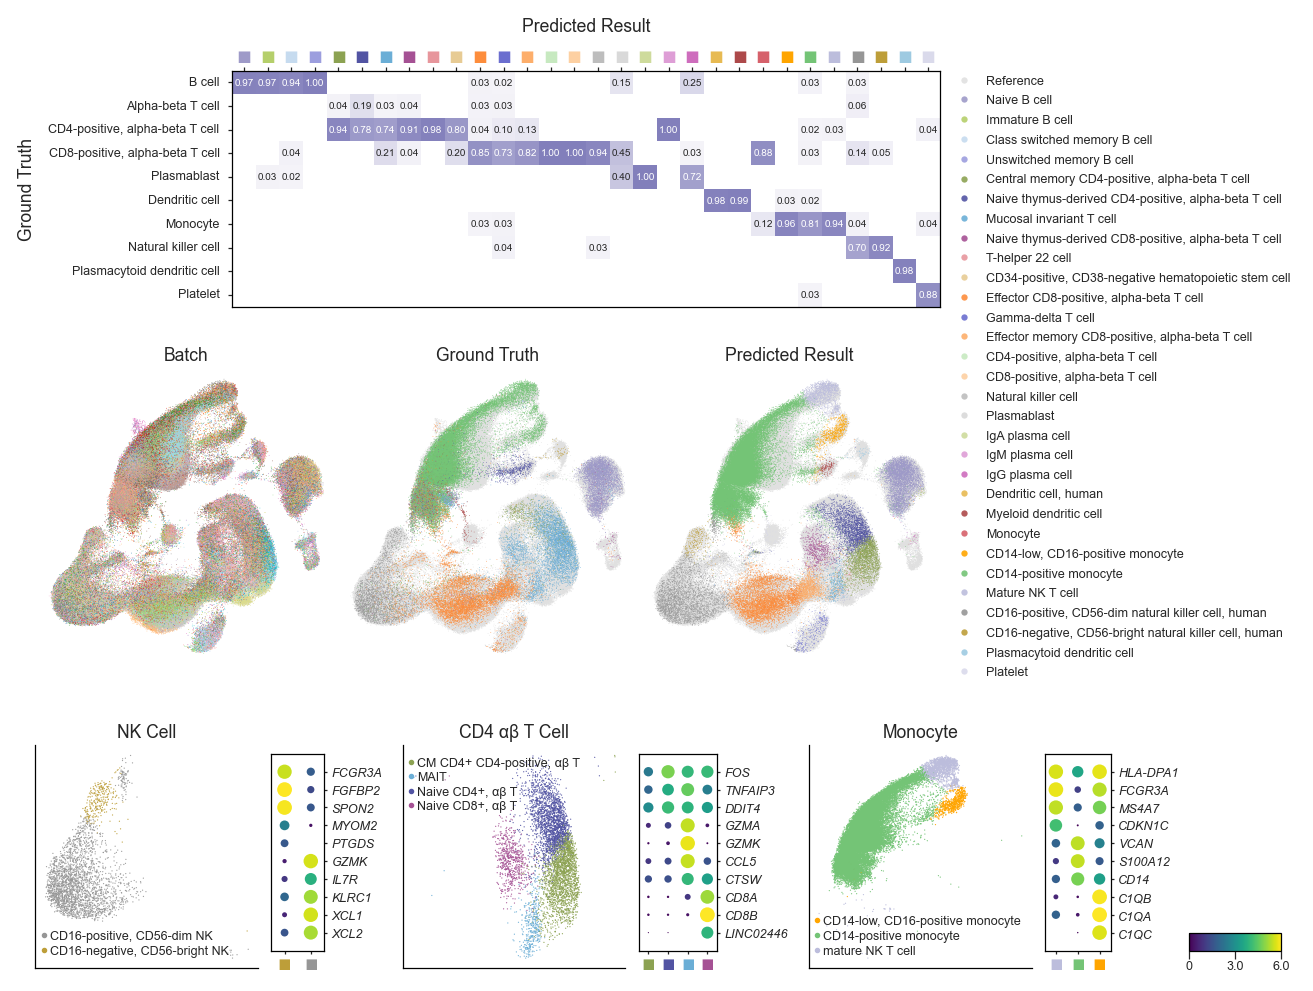

In [12]:
# fig.savefig('../figs/fig3.pdf', dpi=720)
fig

### SUP6

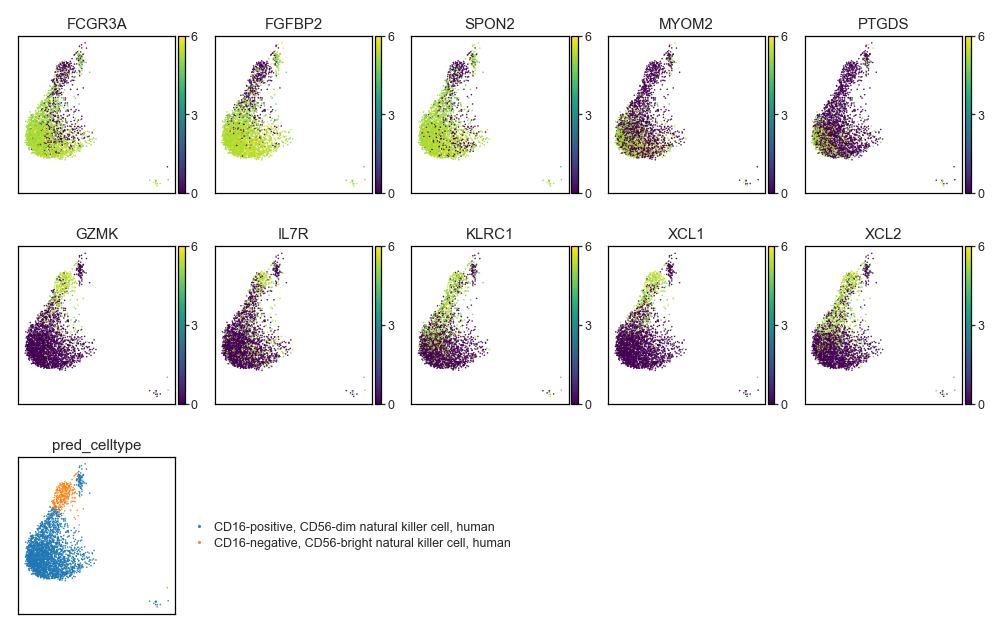

In [13]:
nkfig = result.umap_genex(nk, nk_markers, celltype='pred_celltype')  # .savefig('../sup_figs/sup6a.png', dpi=720)

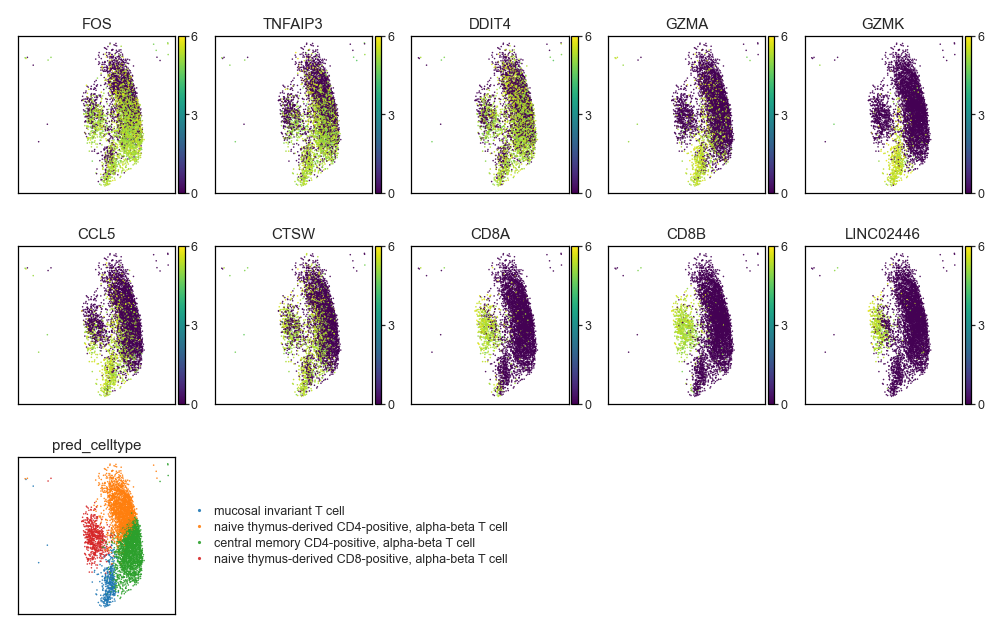

In [14]:
cd4tfig = result.umap_genex(cd4t, cd4t_markers, celltype='pred_celltype')  # .savefig('../figs/supplementary fig6b.pdf', dpi=720)

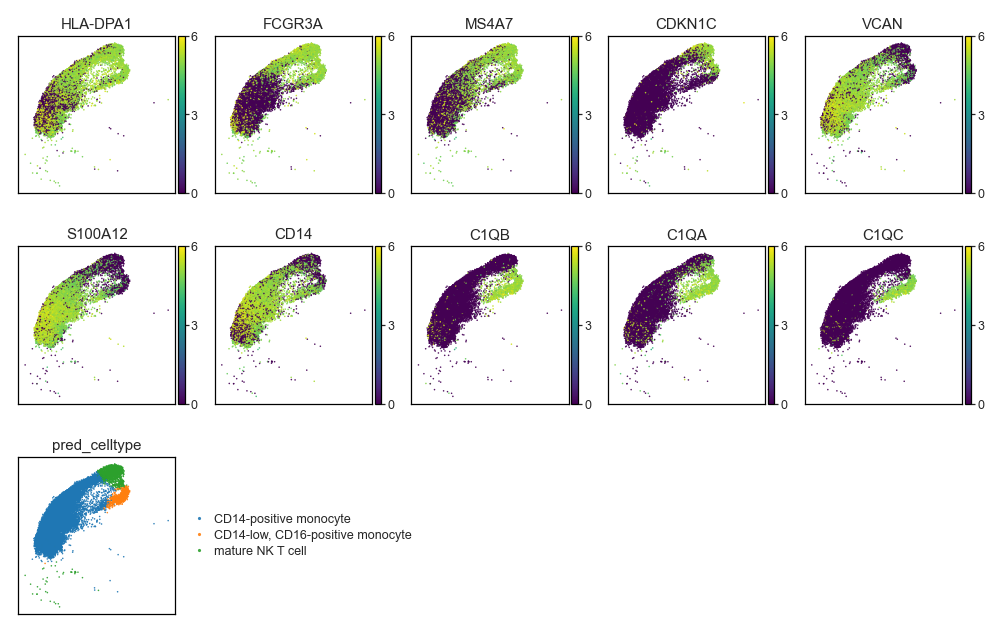

In [15]:
monocytefig = result.umap_genex(monocyte, mono_marker, celltype='pred_celltype')  # .savefig('../sup_figs/sup6c.png', dpi=720)

### SUP7

In [16]:
pbmc_ref = sc.read_h5ad( '../../data/pbmc40/pbmc40.h5ad')
pbmc_ref.obs = pd.concat([pbmc_ref.obs, result.s_result.loc[:, ['pred_celltype', 'pred_cell_prob']]], axis=1)
pbmc_ref.var_names_make_unique()
pbmc_ref = pbmc_ref[pbmc_ref.obs['celltype'] != 'nan', :]
sc.pp.filter_cells(pbmc_ref, min_genes=200)
sc.pp.filter_genes(pbmc_ref, min_cells=3)
sc.pp.normalize_total(pbmc_ref, target_sum=1e6)  # cpm
sc.pp.log1p(pbmc_ref)
pbmc_ref = pbmc_ref[:, pbmc_ref.var.index.isin(pbmc_hvgs)]
pbmc_ref.raw = pbmc_ref
pbmc_ref.obsm['X_umap'] = result.s_umap_result.reindex(pbmc_ref.obs_names).to_numpy()
pbmc_ref.obsm['X_pca'] = result.s_z_result.reindex(pbmc_ref.obs.index).values
pbmc_ref_mono = pbmc_ref[pbmc_ref.obs.celltype.isin(['CD14-low, CD16-positive monocyte', 'CD14-positive monocyte',  'mature NK T cell'])].copy()

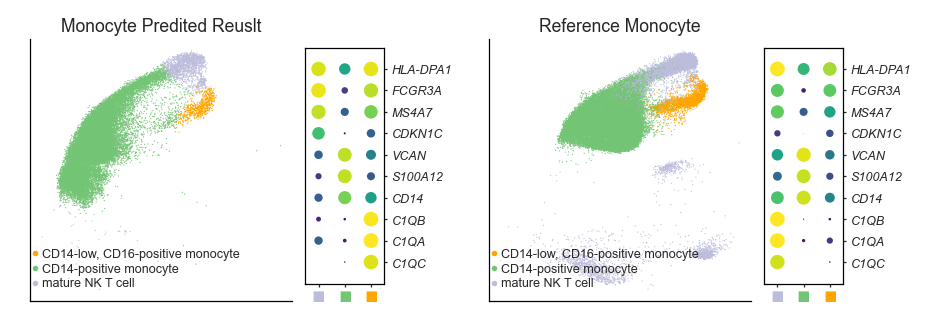

In [17]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()
postions = [[0.15, 0.60, 0.20, 0.20 / (250/185)],
            [0.36, 0.61, 0.06, 0.18 / (250/185)],
            [0.50, 0.60, 0.20, 0.20 / (250/185)],
            [0.71, 0.61, 0.06, 0.18 / (250/185)]]
ax1 = fig.add_axes(postions[0])
ax2 = fig.add_axes(postions[1])
ax3 = fig.add_axes(postions[2])
ax4 = fig.add_axes(postions[3])

monocyte = pbmc_query[(pbmc_query.obs['celltype'] == 'monocyte') & (pbmc_query.obs['pred_celltype'].isin(['CD14-low, CD16-positive monocyte', 'CD14-positive monocyte', 'mature NK T cell'])), :].copy()

mono_marker = ['HLA-DPA1', 'FCGR3A', 'MS4A7',  'CDKN1C','VCAN', 'S100A12', 'CD14', 'C1QB', 'C1QA', 'C1QC',  ]

ct_color_dict = {
    'CD14-low, CD16-positive monocyte': '#ffa500',
    'CD14-positive monocyte': '#74c476',
    'mature NK T cell': '#bcbddc',
}
plot_umap(monocyte, ct_color_dict=ct_color_dict, ax=ax1, title='Monocyte Predited Reuslt')
plot_dotplot(monocyte, mono_marker, groupby_column='pred_celltype', ax=ax2, group_color=['#bcbddc','#74c476',  '#ffa500', ])

plot_umap(pbmc_ref_mono, ct_color_dict=ct_color_dict, ax=ax3, title='Reference Monocyte')
plot_dotplot(pbmc_ref_mono, mono_marker, groupby_column='pred_celltype', ax=ax4, group_color=['#bcbddc','#74c476',  '#ffa500', ], group_index=list(ct_color_dict.keys()))

In [18]:
# fig.savefig('../figs/supplementary fig7.pdf', dpi=720)
# fig.savefig('../sup_figs/sup7.png', dpi=720)